# LXMLS 2017 - Day 6

## Deep Learning II

#### 6.2 Recurrent Neural Networks: Backpropagation Through Time

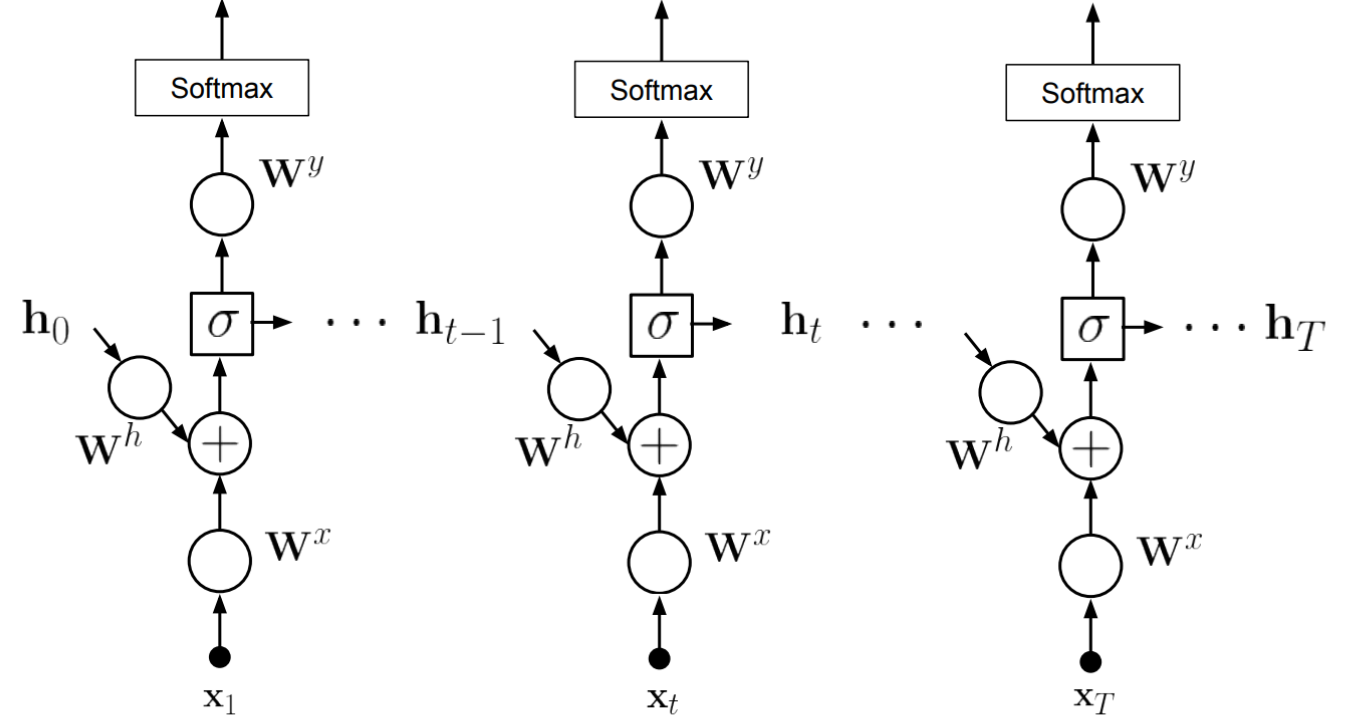

Figure 6.1: The simplest RNN can be seen as replicating a single hidden-layer FF network T times and passing
the intermediate hidden variable ht across different steps. Note that all nodes operate over vector inputs e.g,.
xt ∈ RI. Circles indicate matrix multiplications.

The previous day focused on Feed Forward (FF) networks. These networks are ill suited to learn variable
length patterns since they only accept inputs of a fixed size. In order to learn sequences using neural networks,
we need therefore to define some architecture that is able to process variable length inputs. Recurrent Neural
Networks (RNNs) solve this problem by unfolding the computation graph in time. In other words, the network is replicated as many times as it is necessary to cover the sequence to be modeled. In order to model the
sequence one or more connections across different time instants are created. This allows the network to have a
memory in time and thus capture complex patterns in sequences. In the simplest model, depicted in Fig. 6.1,
and detailed in Algorithm 6.2, a RNN is created by replicating a single hidden-layer FF network T times and
passing the intermediate hidden variable across different steps.

Since RNNs are computation graphs involving the same operations as FF networks, they can also be trained
with backpropagation. However the error is propagated over the length of the entire sequence. This often leads
to numerical problems know as vanishing and exploding gradients. A number of solutions are used to mitigate
this issue. One simple, yet inelegant, method is clipping the gradients to a fixed threshold. Another solution
is to resort to more complex RNN models that are able to better handle long range dependencies and are less
sensitive to this phenomena. It is important to bear in mind, however, that all RNNs still use backpropagation
as seen in the previous day, although it is often referred as Backpropagation through time.

#### Exercise 6.1 
Convince yourself a RNN is just an FF unfolded in time. Run the NumpyRNN code. Set break-points and compare with what you learned about back-propagation in the previous day.

Start by loading data Part-of-speech data and configure it for the exercises

In [1]:
# Add tools
# NOTE: This should only be needed if you do not store the notebook on the lxmls root
import sys
sys.path.append('../../../')
from pdb import set_trace

In [2]:
# Location of Part-of-Speech WSJ Data
WSJ_TRAIN = "../../../data/train-02-21.conll"
WSJ_TEST = "../../../data/test-23.conll"
WSJ_DEV = "../../../data/dev-22.conll"

In [3]:
# Load Part-of-Speech data 
import lxmls.readers.pos_corpus as pcc
corpus = pcc.PostagCorpus()
train_seq = corpus.read_sequence_list_conll(WSJ_TRAIN, max_sent_len=15, max_nr_sent=1000)
test_seq = corpus.read_sequence_list_conll(WSJ_TEST, max_sent_len=15, max_nr_sent=1000)
dev_seq = corpus.read_sequence_list_conll(WSJ_DEV, max_sent_len=15, max_nr_sent=1000) 
# Redo indices so that they are consecutive. Also cast all data to numpy arrays
# of int32 for compatibility with GPUs and theano and add reverse index
train_seq, test_seq, dev_seq = pcc.compacify(train_seq, test_seq, dev_seq, theano=True)
# Get number of words and tags in the corpus
nr_words = len(train_seq.x_dict)
nr_tags = len(train_seq.y_dict)

In [4]:
import lxmls.deep_learning.rnn as rnns
reload(rnns)

<module 'lxmls.deep_learning.rnn' from '../../../lxmls/deep_learning/rnn.pyc'>

In [5]:
# RNN configuration
SEED = 1234       # Random seed to initialize weigths
emb_size = 50     # Size of word embeddings
hidden_size = 20  # size of hidden layer

In [6]:
np_rnn = rnns.NumpyRNN(nr_words, emb_size, hidden_size, nr_tags, seed=SEED)

In [7]:
x0 = train_seq[0].x
y0 = train_seq[0].y

In [8]:
# Forward pass
p_y, y_rnn, h, z1, x = np_rnn.forward(x0, all_outputs=True)
# Compute gradients
numpy_rnn_gradients = np_rnn.grads(x0, y0)

### 6.3 The Scan operation in Theano

Handling variable length computation graphs in an automatic fashion is not simple. Theano provides the scan
function for this purpose. The scan function acts as a symbolic “for” loop. Since, unlike for normal python
“for” loops, it is not possible to put a breakpoint in the scan loop, the design of graphs with scan has to be
handled with care. Toolboxes like Keras conveniently abstract the user from such constructs. However, for
complex designs it will be necessary to be able to use scan or equivalent functions.

#### Exercise 6.2
Understand the basics of scan with this examples. Scan allows you to build computation graphs with a variable number of nodes. It acts as a python "for" loop but it is symbolic. The following example should help you understand the basic scan functionality. It generates a sequence for a given length. Run it and modify it. Try to arrive at an error.

In [9]:
import numpy as np
import theano
import theano.tensor as T
theano.config.optimizer='None'

In [10]:
def square(x): 
    return x**2 

# Python
def np_square_n_steps(nr_steps):
    out = []
    for n in np.arange(nr_steps):
        out.append(square(n))
    return np.array(out)
    
# Theano
nr_steps = T.lscalar('nr_steps')
h, _ = theano.scan(fn=square, sequences=T.arange(nr_steps))
th_square_n_steps = theano.function([nr_steps], h)

In [11]:
print np_square_n_steps(10)
print th_square_n_steps(10)

[ 0  1  4  9 16 25 36 49 64 81]
[ 0  1  4  9 16 25 36 49 64 81]


The following example should help you understand about matrix multiplications and passing values from one iteration to the other. It at each step it we multiply the output of the previous step by a matrix A. We start with an initial vector s0. The matrix and vector are random but normalized to result on a Markov chain.  

In [12]:
# Configuration
nr_states = 3
nr_steps = 5

# Transition matrix
A = np.abs(np.random.randn(nr_states, nr_states))
A = A/A.sum(0, keepdims=True)
# Initial state
s0 = np.zeros(nr_states)
s0[0] = 1

In [13]:
# Numpy version
def np_markov_step(s_tm1): 
    s_t = np.dot(s_tm1, A.T)
    return s_t 

def np_markov_chain(nr_steps, A, s0):
    # Pre-allocate space
    s = np.zeros((nr_steps+1, nr_states))
    s[0, :] = s0
    for t in np.arange(nr_steps):
        s[t+1, :] = np_markov_step(s[t, :])
    return  s

In [14]:
np_markov_chain(nr_steps, A, s0)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.36331926,  0.00998989,  0.62669084],
       [ 0.22093512,  0.07267485,  0.70639002],
       [ 0.22723631,  0.08820146,  0.68456223],
       [ 0.23850484,  0.08797088,  0.67352428],
       [ 0.24099095,  0.08686008,  0.67214897]])

In [15]:
# Theano version
# Store variables as shared variables
th_A = theano.shared(A, name='A', borrow=True)
th_s0 = theano.shared(s0, name='s0', borrow=True)
# Symbolic variable for the number of steps
th_nr_steps = T.lscalar('nr_steps')

def th_markov_step(s_tm1): 
    s_t = T.dot(s_tm1, th_A.T)
    # Remember to name variables
    s_t.name = 's_t'
    return s_t 

s, _ = theano.scan(th_markov_step, 
                   outputs_info=[dict(initial=th_s0)], 
                   n_steps=th_nr_steps)
th_markov_chain = theano.function([th_nr_steps], T.concatenate((th_s0[None, :], s), 0))

In [16]:
th_markov_chain(nr_steps)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.36331926,  0.00998989,  0.62669084],
       [ 0.22093512,  0.07267485,  0.70639002],
       [ 0.22723631,  0.08820146,  0.68456223],
       [ 0.23850484,  0.08797088,  0.67352428],
       [ 0.24099095,  0.08686008,  0.67214897]])

### 6.4 A RNN in Theano for Part-of-Speech Tagging

#### Exercise 6.3 

Complete the theano code for a RNN inside lxmls/deep learning/rnn.py. Use exercise 6.1 for a numpy
example and 6.2 to learn how to handle scan. Keep in mind that you only need to implement the forward pass! Theano
will handle backpropagation for us.

In [17]:
rnn = rnns.RNN(nr_words, emb_size, hidden_size, nr_tags, seed=SEED)

Resolution of the exercise 6.3

In [28]:
def _forward(self, _x, _h0=None):                                                                                                        

    # Default initial hidden is allways set to zero                                                                                      
    if _h0 is None:                                                                                                                      
        h0  = np.zeros((1, self.n_hidd)).astype(theano.config.floatX)                                                                    
        _h0 = theano.shared(h0, borrow=True)                                                                                             

    # COMPUTATION GRAPH                                                                                                                  

    # Get parameters in nice form                                                                                                        
    _W_e, _W_x, _W_h, _W_y = self.param                                                                                                  

    # NOTE: Since _x contains the indices rather than full one-hot vectors,                                                              
    # use _W_e[:, _x].T instead of T.dot(_x, _W_e.T)                                                                                     

    ###########################                                                                                                          
    # Solution to Exercise 6.3                                                                                                           
    ###########################                                                                                                          
    # Embedding layer                                                                                                                    
    _z1 = _W_e[ :, _x ].T                                                                                                                

    def rnn_step( _x_tm1, _h_tm1, _W_x, W_h ): # This defines what to do at each step                                                    
        return T.nnet.sigmoid( T.dot( _x_tm1, _W_x.T ) + T.dot( _h_tm1, W_h.T ) )                                                        

    # This creates the variable length computation graph (unrols the rnn)                                                                
    _h, updates = theano.scan( fn=rnn_step, sequences = _z1, outputs_info = dict( initial=_h0 ), non_sequences= [_W_x ,_W_h ] )          

    # Remove intermediate empty dimension                                                                                                
    _z2 = _h[:,0,:]                                                                                                                      
    
    #################################
    # End of solution to Exercise 6.3                                                                                                    
    #################################                                                                                                           

    # Output layer                                                                                                                       
    _p_y = T.nnet.softmax(T.dot(_z2, _W_y.T))                                                                                            

    return _p_y                                                                                                                          

In [18]:
# Compile the forward pass function
x = T.ivector('x')
th_forward = theano.function([x], rnn._forward(x).T)

When working with theano, it is more difficult to localize the source of errors. It is therefore important to work step by
step and test the code frequently. To debug we suggest to implement and compile the forward pass first. You can use this
code for testing. If it raises no error you are good to go.

In [19]:
assert np.allclose(th_forward(x0), np_rnn.forward(x0)), "Numpy and Theano forward pass differ!"

Once you are confident the forward pass is working you can test the gradients

In [20]:
# Compile function returning the list of gradients
x = T.ivector('x')     # Input words
y = T.ivector('y')     # gold tags 
p_y = rnn._forward(x)
cost = -T.mean(T.log(p_y)[T.arange(y.shape[0]), y])
grads_fun = theano.function([x, y], [T.grad(cost, par) for par in rnn.param])

In [21]:
# Compare numpy and theano gradients
theano_rnn_gradients = grads_fun(x0, y0)
for n in range(len(theano_rnn_gradients)): 
    assert np.allclose(numpy_rnn_gradients[n], theano_rnn_gradients[n]), \
    "Numpy and Theano gradients differ in step n"

Finally, its time to test our network!. For this, lets first compile a function that does predictions

In [22]:
rnn_prediction = theano.function([x], T.argmax(p_y, 1))
# Lets test the predictions
def test_model(sample_seq, rnn_prediction):
    words = [train_seq.word_dict[wrd] for wrd in sample_seq.x]
    tags = [train_seq.tag_dict[pred] for pred in rnn_prediction(sample_seq.x)]
    print ["/".join([word, tag]) for word , tag in zip(words, tags)]

In [23]:
test_model(train_seq[0], rnn_prediction)

[u'Ms./noun', u'Haag/noun', u'plays/noun', u'Elianti/noun', u'./noun']


Now lets define the optimization parameters and compile a batch update function

In [24]:
lrate = 0.5
n_iter = 5

In [25]:
# Get list of SGD batch update rule for each parameter
updates = [(par, par - lrate*T.grad(cost, par)) for par in rnn.param]
# compile
rnn_batch_update = theano.function([x, y], cost, updates=updates)

Finally it is time to run SGD. You can use the following code for this purpose

In [26]:
nr_words = sum([len(seq.x) for seq in train_seq])
for i in range(n_iter):
    
    # Training
    cost = 0
    errors = 0
    for n, seq in enumerate(train_seq):
        cost += rnn_batch_update(seq.x, seq.y)
        errors += sum(rnn_prediction(seq.x) != seq.y)
    acc_train = 100*(1-errors*1./nr_words) 
    print "Epoch %d: Train cost %2.2f Acc %2.2f %%" % (i+1, cost, acc_train), 
    
    # Evaluation    
    errors = 0
    for n, seq in enumerate(dev_seq):
        errors += sum(rnn_prediction(seq.x) != seq.y)  
    acc_dev = 100*(1-errors*1./nr_words) 
    print " Devel Acc %2.2f %%" % acc_dev
    sys.stdout.flush()

Epoch 1: Train cost 2305.56 Acc 39.76 %  Devel Acc 82.51 %
Epoch 2: Train cost 1086.04 Acc 79.20 %  Devel Acc 91.59 %
Epoch 3: Train cost 399.32 Acc 96.87 %  Devel Acc 94.17 %
Epoch 4: Train cost 192.59 Acc 99.02 %  Devel Acc 94.60 %
Epoch 5: Train cost 109.20 Acc 99.37 %  Devel Acc 94.64 %


Test the effect of using pre-trained embeddings. Run the following code to download the embeddings, reset the layer parameters and initialize the embedding layer with the pre-trained embeddings. Then run the training code above.

In [27]:
# Embeddings Path
EMBEDDINGS = "../../../data/senna_50"
import lxmls.deep_learning.embeddings as emb
import os
reload(emb)
if not os.path.isfile(EMBEDDINGS):
    emb.download_embeddings('senna_50', EMBEDDINGS)
E = emb.extract_embeddings(EMBEDDINGS, train_seq.x_dict) 
# Reset model to remove the effect of training
rnn = rnns.reset_model(rnn, seed=SEED)
# Set the embedding layer to the pre-trained values
rnn.param[0].set_value(E.astype(theano.config.floatX))

Getting embeddings for the vocabulary 18/4786

Getting embeddings for the vocabulary 20/4786

Getting embeddings for the vocabulary 71/4786

Getting embeddings for the vocabulary 97/4786 

Getting embeddings for the vocabulary 140/4786

Getting embeddings for the vocabulary 152/4786

Getting embeddings for the vocabulary 206/4786

Getting embeddings for the vocabulary 210/4786 

Getting embeddings for the vocabulary 264/4786 

Getting embeddings for the vocabulary 271/4786 

Getting embeddings for the vocabulary 312/4786

Getting embeddings for the vocabulary 318/4786

Getting embeddings for the vocabulary 365/4786

Getting embeddings for the vocabulary 367/4786 

Getting embeddings for the vocabulary 400/4786

Getting embeddings for the vocabulary 3618/4786                               
24.4% missing embeddings, set to random


### 6.5 The Importance of Pre-training
One of the key insights that has played a role in the rise of deep learning in NLP tasks is the use of neural
word-embeddings. These are just numeric representations of words that can be learned from unsupervised
data using simple FF networks such as e.g. skip-grams.
Such representations can be plugged into supervised models such as the RNN that we just trained to initialize
its initial layer. The use of pre-trained embeddings very often leads to important improvements in
performance.

#### Exercise 6.4 
Test the effect of using pre-trained embeddings. Run the following code to download the embeddings. Reset
the layer parameters and initialize the embedding layer with the pre-trained embeddings. Then run the training code from
the last exercise.

In [29]:
lstm = rnns.LSTM(nr_words, emb_size, hidden_size, nr_tags)
lstm_prediction = theano.function([x], 
                                  T.argmax(lstm._forward(x), 1))
lstm_cost = -T.mean(T.log(lstm._forward(x))[T.arange(y.shape[0]), y])

In [30]:
# Get list of SGD batch update rule for each parameter
lstm_updates = [(par, par - lrate*T.grad(lstm_cost, par)) for par in lstm.param]
# compile
lstm_batch_update = theano.function([x, y], lstm_cost, 
                                    updates=lstm_updates)

In [31]:
nr_words = sum([len(seq.x) for seq in train_seq])
for i in range(n_iter):
    
    # Training
    cost = 0
    errors = 0
    for n, seq in enumerate(train_seq):
        cost += lstm_batch_update(seq.x, seq.y)
        errors += sum(lstm_prediction(seq.x) != seq.y)
    acc_train = 100*(1-errors*1./nr_words) 
    print "Epoch %d: Train cost %2.2f Acc %2.2f %%" % (i+1, cost, acc_train), 
    
    # Evaluation:
    errors = 0
    for n, seq in enumerate(dev_seq):
        errors += sum(lstm_prediction(seq.x) != seq.y)  
    acc_dev = 100*(1-errors*1./nr_words) 
    print " Devel Acc %2.2f %%" % acc_dev
    sys.stdout.flush()

Epoch 1: Train cost 2440.80 Acc 29.01 %  Devel Acc 75.36 %
Epoch 2: Train cost 2011.30 Acc 42.07 %  Devel Acc 79.87 %
Epoch 3: Train cost 1547.16 Acc 56.47 %  Devel Acc 82.05 %
Epoch 4: Train cost 1310.40 Acc 62.94 %  Devel Acc 83.41 %
Epoch 5: Train cost 1178.63 Acc 67.45 %  Devel Acc 84.85 %
